# Variational Autoencoders (VAE)

Based on [`vae/train.py`](https://github.com/google/flax/blob/main/examples/vae/train.py) Flax example.

Stochastic gradient variational Bayes (SGVB). VLB Monte Carlo estimate
$$
    \hat{\mathcal{L}}(\boldsymbol\theta, \boldsymbol\phi; {\bf X}) = \sum_{n=1}^N \log p_{\theta_x}({\bf x}_n \vert \hat{\bf z}_n) + \log p_{\theta_z}(\hat{\bf z}_n) - \log p(\hat{\boldsymbol\varepsilon}_n) + \log d_\phi(\hat{\boldsymbol\varepsilon}_n, {\bf x}_n)
$$

In [79]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from flax.training import train_state

In [2]:
%config InlineBackend.figure_format = "retina"

In [18]:
# Taken from jax's website
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
from torchvision.datasets import MNIST


class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [91]:
X_train = jnp.array(mnist_train.data)
n_train, *_ = X_train.shape
# "Gaussanised" MNIST
Xf_train = X_train.reshape(-1, 28 ** 2)
Xf_train = X_train / X_train.max()
Xf_train = (Xf_train - Xf_train.mean()) / Xf_train.std()

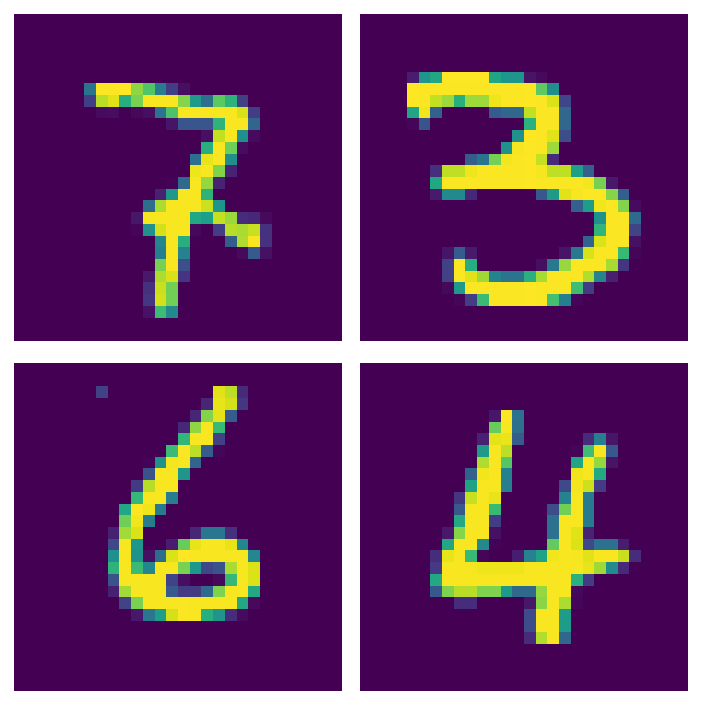

In [92]:
key = jax.random.PRNGKey(314)
key_sample, key = jax.random.split(key)
ixs = jax.random.choice(key, n_train, (4,))

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()
for ix, ax in zip(ixs, axs):
    ax.imshow(Xf_train[ix].reshape(28, 28))
    ax.axis("off")
plt.tight_layout()

In [73]:
class Encoder(nn.Module):
    """
    For the inference model p(z|x)
    """
    # For the inference model p(z\x)
    latent_dim: int
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(100)(x)
        z = nn.relu(z)
        z = nn.Dense(100)(z)
        z = nn.relu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z
    
    
class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    observed_dim: int
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(100)(z)
        x = nn.relu(x)
        x = nn.Dense(100)(x)
        x = nn.relu(x)
        mean_x = nn.Dense(self.observed_dim)(x)
        logvar_x = nn.Dense(self.observed_dim)(x)
        return mean_x, logvar_x


class VAE(nn.Module):
    latent_dim: int
    observed_dim: int
    
    @staticmethod
    def reparameterise(key, mean, logvar):
        std = jnp.exp(logvar / 2)
        eps = jax.random.normal(key, logvar.shape)
        z = mean + eps * std
        return z
    
    def setup(self):
        # Called at .init
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder(self.observed_dim)
    
    def __call__(self, x, key_eps):
        mean_z, logvar_z = self.encoder(x)
        z = VAE.reparameterise(key_eps, mean_z, logvar_z)
        mean_x, logvar_x = self.decoder(z)
        return (mean_z, logvar_z), (mean_x, logvar_x)

In [89]:
def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(key, params, opt_step, X, y, sbatch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
    
    return params, opt_step

In [74]:
VAE.reparameterise(key, 0, jnp.array([1,2,3]))

DeviceArray([ 1.745846 , -1.3533316,  2.0788307], dtype=float32)

In [87]:
observed_dim = 28 ** 2
latent_dim = 20
batch_size = 200
learning_rate = 1e-3
batch_init = jnp.ones((batch_size, observed_dim))

key_params_init, key_eps_init, key = jax.random.split(key, 3)
model  = VAE(latent_dim, observed_dim)

params_init = model.init(key_init, batch_init, key_eps_init)
tx = optax.adam(learning_rate)

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=tx
)

In [ ]:
X

In [95]:
model.apply(params_init, Xf_train[:10], key)

ScopeParamShapeError: Inconsistent shapes between value and initializer for parameter "kernel" in "/encoder/Dense_0": (784, 100), (28, 100). (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.ScopeParamShapeError)

In [40]:
def sgvb_estimator(params):
    """
    ** Loss function **
    Stochastic Gradient Variational Bayes (SGVB)
    estimator.
    """
    ...